In [1]:
import os
from pathlib import Path
from huggingface_hub import login
from datasets import load_dataset

In [ ]:
login()
dataset = load_dataset("nvidia/Nemotron-Personas")

In [2]:
import pandas as pd

df = pd.read_parquet("../Nemotron_Personas.parquet").iloc[:3000,:]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   uuid                        3000 non-null   object
 1   professional_persona        3000 non-null   object
 2   sports_persona              3000 non-null   object
 3   arts_persona                3000 non-null   object
 4   travel_persona              3000 non-null   object
 5   culinary_persona            3000 non-null   object
 6   persona                     3000 non-null   object
 7   cultural_background         3000 non-null   object
 8   skills_and_expertise        3000 non-null   object
 9   skills_and_expertise_list   3000 non-null   object
 10  hobbies_and_interests       3000 non-null   object
 11  hobbies_and_interests_list  3000 non-null   object
 12  career_goals_and_ambitions  3000 non-null   object
 13  sex                         3000 non-null   obje

In [ ]:
df.columns

Index(['uuid', 'professional_persona', 'sports_persona', 'arts_persona',
       'travel_persona', 'culinary_persona', 'persona', 'cultural_background',
       'skills_and_expertise', 'skills_and_expertise_list',
       'hobbies_and_interests', 'hobbies_and_interests_list',
       'career_goals_and_ambitions', 'sex', 'age', 'marital_status',
       'education_level', 'bachelors_field', 'occupation', 'city', 'state',
       'zipcode', 'country'],
      dtype='object')

In [ ]:
not_required_columns=['zipcode', 'country']
persona_columns=['persona', 'professional_persona', 'sports_persona',
                'arts_persona', 'travel_persona', 'culinary_persona']
categorical_columns=['sex', 'marital_status','education_level', 
                     'bachelors_field', 'occupation', 'city', 'state']

In [ ]:
df[persona_columns].head()

,persona,professional_persona,sports_persona,arts_persona,travel_persona,culinary_persona
0,"Mary Alberti is a routine‑obsessed, bullet‑jou...",Mary Alberti is a front‑line food service spec...,Mary Alberti fuels their fitness routine by cl...,Mary Alberti finds creative inspiration in the...,Mary Alberti prefers meticulously planned week...,Mary Alberti showcases an intermediate culinar...
1,Alicia Gonzalez fuses scientific precision wit...,"Alicia Gonzalez, a research scientist speciali...","Alicia Gonzalez, an enthusiastic hiker who spe...","Alicia Gonzalez, an abstract painter and gener...","Alicia Gonzalez, who mixes meticulous research...","Alicia Gonzalez, an intermediate‑to‑advanced h..."
2,"Deeva Cintron, an 85‑year‑old garden‑loving qu...","Deeva Cintron, an 85‑year‑old community financ...","Deeva Cintron, a devoted fan of the Detroit Ti...","Deeva Cintron, an avid quilt maker and histori...","Deeva Cintron, who prefers meticulously planne...","Deeva Cintron, who delights in homestyle cooki..."
3,"Maria Buendia, a 34‑year‑old, channels their c...","Maria Buendia, a 34‑year‑old community‑focused...","Maria Buendia, a 34‑year‑old, stays active by ...","Maria Buendia, a 34‑year‑old, immerses themsel...","Maria Buendia, a 34‑year‑old, prefers weekend ...","Maria Buendia, a 34‑year‑old, blends heritage ..."
4,Julio Simmons is a 49‑year‑old restless polyma...,"Julio Simmons, a 49‑year‑old interdisciplinary...","Julio Simmons, an avid hiker of the Finger Lak...",Julio Simmons immerses themselves in a spectru...,Julio Simmons favours purposeful travel that f...,Julio Simmons approaches cooking as an experim...


## expertise_list

-TF-IDF 

In [ ]:
import ast
df['hobbies_and_interests_list'] = df['hobbies_and_interests_list'].apply(ast.literal_eval)

In [ ]:
total_hobbies = set()
for hobbies in df['hobbies_and_interests_list']:
    total_hobbies.update(hobbies)


len(total_hobbies)

12751

In [ ]:
total_hobbies


{'playing cards',
 'drawing (pencil and digital)',
 'Sketching urban landscapes',
 'Solo travel to historic sites',
 'Playing guitar at local gatherings',
 'Writing personal memoirs',
 'Community theater set building',
 'gardening (vegetables and native plants)',
 'walking and birdwatching in local parks',
 'sing‑along music',
 'Reading business and self‑improvement books',
 'Stargazing with a telescope',
 'Tech meetups (data science, Python)',
 'Solving Sudoku puzzles',
 'Attending local high school football games',
 'Playing open‑world video games',
 'Online Art Lectures',
 'Watching classic telenovelas',
 'Active participation in local Catholic parish',
 'Robotics club (Scratch & Lego Mindstorms)',
 'Classical and jazz music listening',
 'Exploring scenic drives on off-days',
 'listening to gospel music',
 'Volunteering at a local food pantry',
 'Reading historical fiction and Peruvian literature',
 'Church small-group bible study',
 'Live music and salsa dancing',
 'Toastmasters/pu

In [4]:
import json

JSON_FILE = '../all_hobbies.json'

try:
    with open(JSON_FILE, 'r') as f:
        total_hobbies = json.load(f)
    print("Successfully loaded 'total_hobbies' from JSON file.")

except FileNotFoundError:
    print(f"JSON file '{JSON_FILE}' not found.")
    with open(JSON_FILE, 'w') as f:
        json.dump(list(total_hobbies), f)

except json.JSONDecodeError:
    print(f"Error decoding JSON from file '{JSON_FILE}'.")


Successfully loaded 'total_hobbies' from JSON file.


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

import networkx as nx

model = SentenceTransformer("all-MiniLM-L6-v2")

hobby_list = list(total_hobbies)
embeddings = model.encode(hobby_list, show_progress_bar=True)

similarity_matrix = cosine_similarity(embeddings)

threshold = 0.75



G = nx.Graph()
G.add_nodes_from(range(len(hobby_list)))

for i in range(len(hobby_list)):
    for j in range(i + 1, len(hobby_list)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j)

merged_hobbies = []
for component in nx.connected_components(G):
    group = [hobby_list[idx] for idx in component]
    merged_hobbies.append(group)

canonical_hobbies = [g[0] for g in merged_hobbies]

df_merged = pd.DataFrame({
    "canonical_hobby": canonical_hobbies,
    "merged_group": [", ".join(g) for g in merged_hobbies]
})

df_merged.to_csv("semantically_merged_hobbies.csv", index=False)
print(f"✅ {len(canonical_hobbies)} unique semantic hobby groups created and saved to semantically_merged_hobbies.csv")


Batches:   0%|          | 0/399 [00:00<?, ?it/s]

✅ 4515 unique semantic hobby groups created and saved to semantically_merged_hobbies.csv


In [10]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm


model_name = "Qwen/Qwen3-Embedding-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


df_merged = pd.read_csv("semantically_merged_hobbies.csv")
hobbies = df_merged["canonical_hobby"].tolist()


def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()


embeddings = []
for hobby in tqdm(hobbies, desc="Creating embeddings"):
    embeddings.append(get_embedding(hobby))

embeddings = np.array(embeddings)
np.save("canonical_embeddings_qwen.npy", embeddings)

print(f"✅ Embeddings created for {len(hobbies)} hobbies and saved as canonical_embeddings_qwen.npy")

Creating embeddings: 100%|██████████| 1166/1166 [02:47<00:00,  6.97it/s]

✅ Embeddings created for 1166 hobbies and saved as canonical_embeddings_qwen.npy


In [6]:
%pip install hdbscan scikit-learn

   ---------------------------------------- 0.0/811.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/811.2 kB ? eta -:--:--
   ------------ --------------------------- 262.1/811.2 kB ? eta -:--:--
   -------------------------------------- - 786.4/811.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 811.2/811.2 kB 1.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import hdbscan
import numpy as np
import pandas as pd

# Load embeddings if not in memory (optional, assuming they are from previous cell)
# embeddings = np.load("canonical_embeddings_qwen.npy")

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings)

df_hdbscan = pd.DataFrame({
    "hobby": hobbies,
    "cluster": cluster_labels
})

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise = list(cluster_labels).count(-1)

print(f"HDBSCAN found {num_clusters} clusters and {num_noise} noise points.")
# df_hdbscan.to_csv("hdbscan_clusters.csv", index=False)

c:\Users\alt_user\anaconda3\envs\prop_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alt_user\anaconda3\envs\prop_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 105 clusters and 535 noise points.


In [14]:
%pip install umap-learn matplotlib seaborn



   ---------------------------------------- 2/2 [umap-learn]

Note: you may need to restart the kernel to use updated packages.


In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Filter out noise points (-1) for metric calculation if desired, 
# but often we want to know how well the clustered points are separated.
# Here we calculate metrics on clustered data only.
clustered_mask = cluster_labels != -1
if clustered_mask.sum() > 1:
    sil_score = silhouette_score(embeddings[clustered_mask], cluster_labels[clustered_mask])
    db_score = davies_bouldin_score(embeddings[clustered_mask], cluster_labels[clustered_mask])
    print(f"Silhouette Score: {sil_score:.3f} (closer to 1 is better)")
    print(f"Davies-Bouldin Index: {db_score:.3f} (lower is better)")
else:
    print("Not enough clustered points to calculate metrics.")

Silhouette Score: 0.150 (closer to 1 is better)
Davies-Bouldin Index: 1.608 (lower is better)


c:\Users\alt_user\anaconda3\envs\prop_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


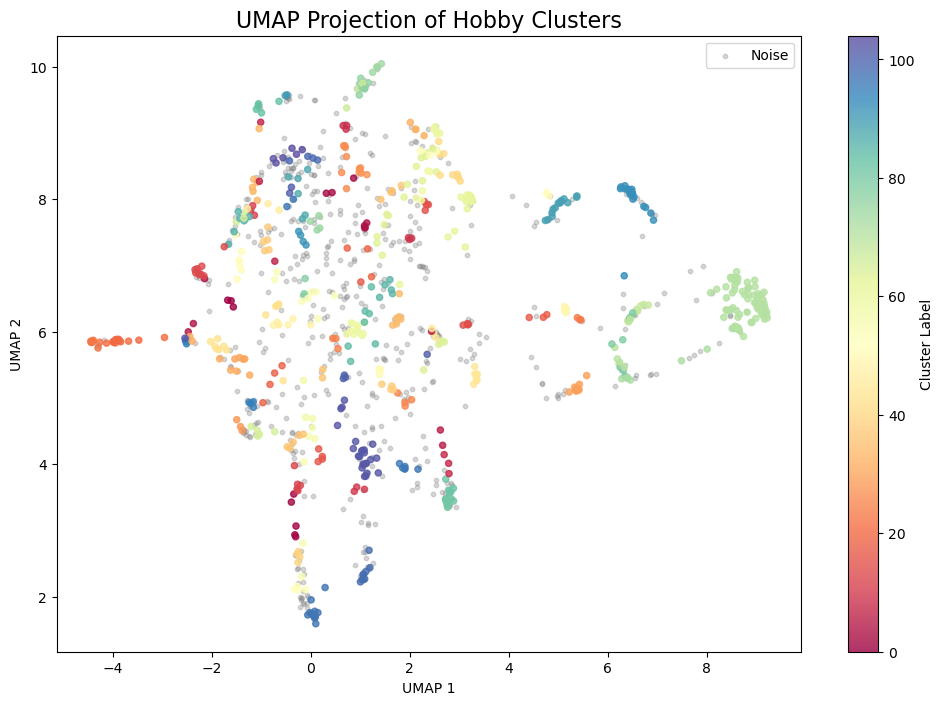

In [15]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
# Plot noise in grey
noise_mask = cluster_labels == -1
plt.scatter(embedding_2d[noise_mask, 0], embedding_2d[noise_mask, 1], c='grey', s=10, alpha=0.3, label='Noise')

# Plot clusters
clustered_mask = ~noise_mask
plt.scatter(embedding_2d[clustered_mask, 0], embedding_2d[clustered_mask, 1], 
            c=cluster_labels[clustered_mask], cmap='Spectral', s=20, alpha=0.8)

plt.title('UMAP Projection of Hobby Clusters', fontsize=16)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

In [ ]:
print("Random samples from top clusters:")
top_clusters = df_hdbscan['cluster'].value_counts().head(5).index.tolist()
if -1 in top_clusters:
    top_clusters.remove(-1)

for cluster_id in top_clusters:
    print(f"\nCluster {cluster_id}:")
    sample = df_hdbscan[df_hdbscan['cluster'] == cluster_id]['hobby'].sample(min(5, len(df_hdbscan[df_hdbscan['cluster'] == cluster_id])))
    for item in sample:
        print(f" - {item}")